In [1]:
## import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner, plot_timeseries
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


import torch
from torch import nn as nn
from torch.nn import functional as F

from transformer_common import GeluFeedForward, TransformerConfig, \
    PositionalEmbedding, DistancePositionalEmbedding, AbstractModel, RMSNorm,LinearFeedForward


class Block(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.l_norm1 = RMSNorm(config.n_embed)
        self.attention = attention_provider()
        self.l_norm2 = RMSNorm(config.n_embed)
        self.ffwd = GeluFeedForward(config.n_embed, config.hidden_size, config.n_embed, config.dropout, bias=False)

    def forward(self, x):
        x = x + self.attention(self.l_norm1(x))
        x = x + self.ffwd.forward(self.l_norm2(x))
        return x

class BlockSequence(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.blocks = nn.Sequential(*[Block(config, attention_provider) for _ in range(config.n_layer)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    
class TorchMultiHeadAttention(nn.Module):
    # https: // pytorch.org / docs / stable / generated / torch.nn.functional.scaled_dot_product_attention.html
    def __init__(self, config):
        super().__init__()

        num_heads = config.n_head
        embed_dimension = config.n_embed
        is_causal = config.causal
        dropout = config.dropout
        bias = False

        assert embed_dimension % num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(embed_dimension, 3 * embed_dimension, bias=bias)
        # output projection
        self.c_proj = nn.Linear(embed_dimension, embed_dimension, bias=bias)
        # regularization
        self.dropout = dropout
        self.resid_dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.embed_dimension = embed_dimension
        # Perform causal masking
        self.is_causal = is_causal

    def forward(self, x):
    
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        query_projected = self.c_attn(x)

        batch_size = query_projected.size(0)
        embed_dim = query_projected.size(2)
        head_dim = embed_dim // (self.num_heads * 3)

        query, key, value = query_projected.chunk(3, -1)
        query = query.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # Apply attention with modified scores
        if self.training:
            dropout = self.dropout
            is_causal = self.is_causal
        else:
            dropout = 0.0
            is_causal = False

        y = F.scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=dropout,
                                           is_causal=is_causal)

        y = y.transpose(1, 2).view(batch_size, -1, self.num_heads * head_dim)

        y = self.resid_dropout(self.c_proj(y))
        return y


class TorchTransformerModel(AbstractModel):
    def __init__(self, config):
        super().__init__(config)
        # self.pos_emb1 = PositionalEmbedding(config)
        self.ffwd1 = GeluFeedForward(config.input_embed, config.hidden_size, config.n_embed, config.dropout, bias=True)
        self.t1 = BlockSequence(config, lambda: TorchMultiHeadAttention(config))
        self.ffwd2 = GeluFeedForward(config.n_embed, config.hidden_size, config.output_embed, config.dropout, bias=True)

    def forward(self, inp):
        x = inp
        b, t, c = x.shape
        x = self.ffwd1(x)
        # pos_emb = self.pos_emb1(b, t)
        x = self.t1(x)
        x = self.ffwd2(x)
        return x



False


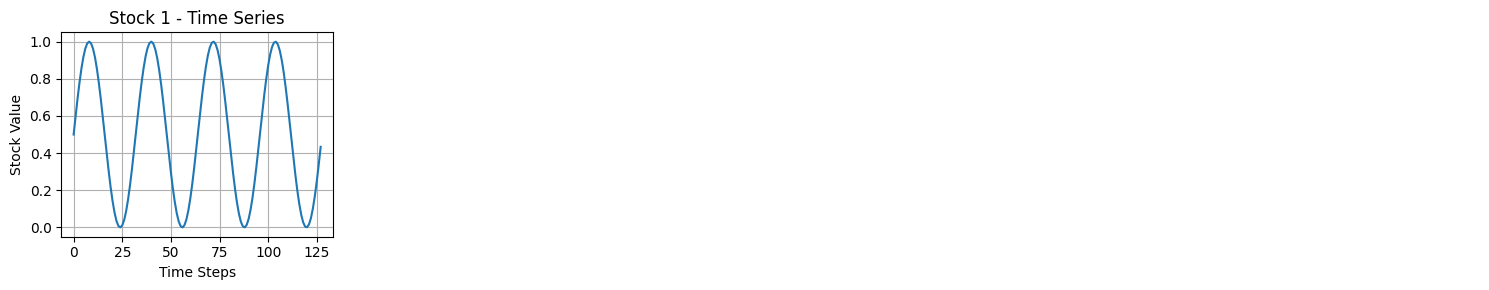

In [2]:
import torch
import math

my_device = 'cpu'
# my_device = 'mps'

# Parameters
n = 128  # Number of data points
num_of_channels = 1   

# Generate a time series of n points
t = torch.linspace(0, math.pi * n // 16, n)

# Generate sine values for the batch
sin_values = torch.sin(t).unsqueeze(1).repeat(1, num_of_channels).transpose(0,1)

sin_values = (sin_values + 1) / 2  # [0, 1]

plot_timeseries(sin_values, num_charts=1)

sin_values = sin_values.transpose(0, 1).to(my_device)

In [3]:
pred_ahead = 32
# inp_clean_data = sin_values[0: sin_values.shape[0] - pred_ahead + 1,:]
inp_clean_data = sin_values.squeeze(1).unfold(dimension=0, size=pred_ahead, step=1)
outp_clean_data = inp_clean_data[pred_ahead:,:]
inp_clean_data = inp_clean_data[:-pred_ahead,:]

In [4]:
inp_clean_data[0:1, :].shape

torch.Size([1, 32])

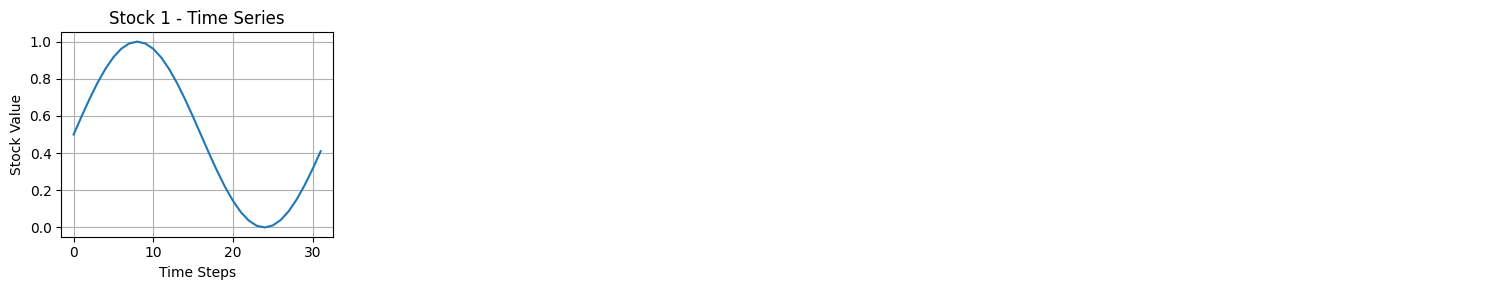

In [5]:
plot_timeseries(inp_clean_data[0:1, :], num_charts=1)

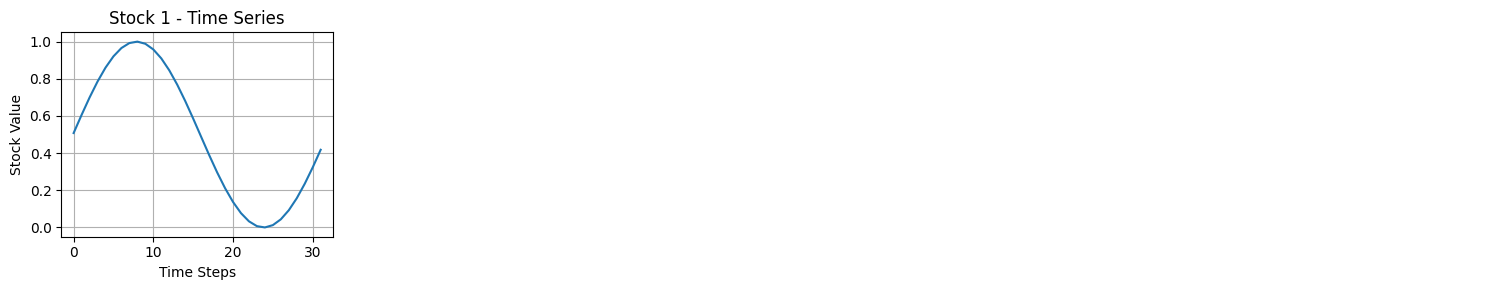

In [6]:
plot_timeseries(outp_clean_data[0:1, :], num_charts=1)

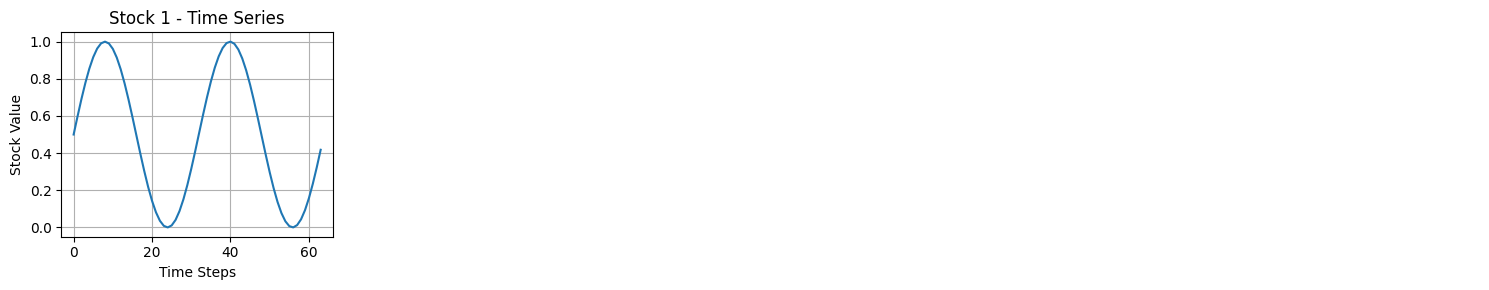

In [7]:
plot_timeseries( torch.cat([inp_clean_data[0:1, :], outp_clean_data[0:1, :]], dim=1), num_charts=1)

In [8]:
config = TransformerConfig(
    precision=torch.float32,
    batch_size=128,
    block_size=1,
    causal=True,
    input_embed=pred_ahead,
    n_embed=64,
    output_embed=pred_ahead,
    n_head=8,
    n_layer=8,
    learning_rate=1e-4,
    shift_output=0,
    my_device=my_device
)
config.eval_interval=500
config.save_model_periodically_every_n_iterations = -1

trainer1 = TransformerRunner(config, TorchTransformerModel(config), inp_clean_data, outp_clean_data) #inp_clean_data

# trainer1.load_model('abc')

trainer1.train_iterate_n(20000)

trainer1.save_model('abc')

Using device: cpu
0.444512 M parameters
step 0: rmse train loss 0.6183, rmse val loss 0.6009, sec/iter 3.814697265625e-09
step 500: rmse train loss 0.2043, rmse val loss 0.2047, sec/iter 0.006985990524291992
step 1000: rmse train loss 0.1981, rmse val loss 0.1977, sec/iter 0.006783684253692627
step 1500: rmse train loss 0.1976, rmse val loss 0.1977, sec/iter 0.006741444110870362
step 2000: rmse train loss 0.1966, rmse val loss 0.1956, sec/iter 0.006718067646026611
step 2500: rmse train loss 0.1961, rmse val loss 0.1957, sec/iter 0.006789668083190918
step 3000: rmse train loss 0.1947, rmse val loss 0.1961, sec/iter 0.006951930522918701
step 3500: rmse train loss 0.1948, rmse val loss 0.1972, sec/iter 0.007072268009185791
step 4000: rmse train loss 0.1967, rmse val loss 0.1948, sec/iter 0.007082288265228272
step 4500: rmse train loss 0.1932, rmse val loss 0.1948, sec/iter 0.00724590015411377
step 5000: rmse train loss 0.1945, rmse val loss 0.1948, sec/iter 0.0072329678535461425
step 5500

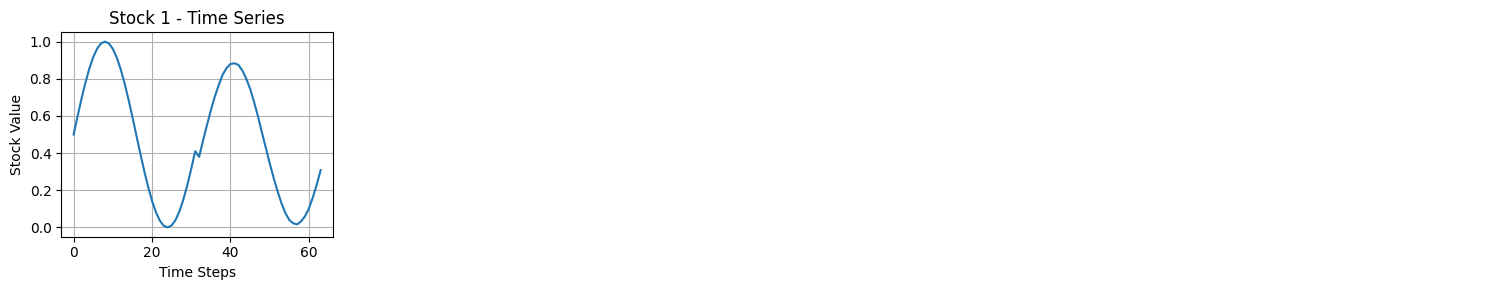

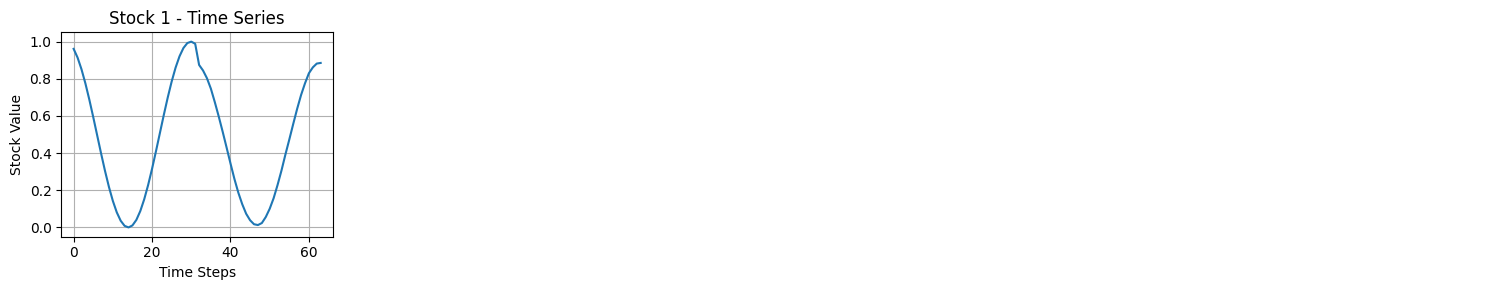

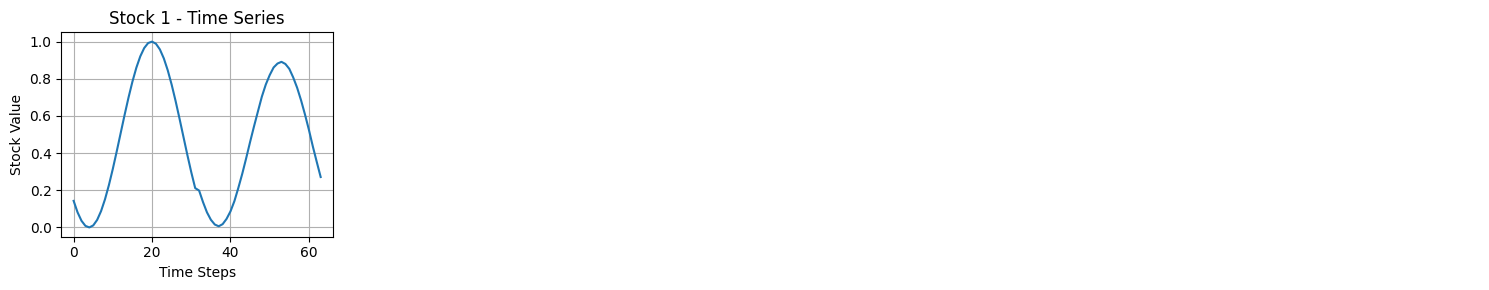

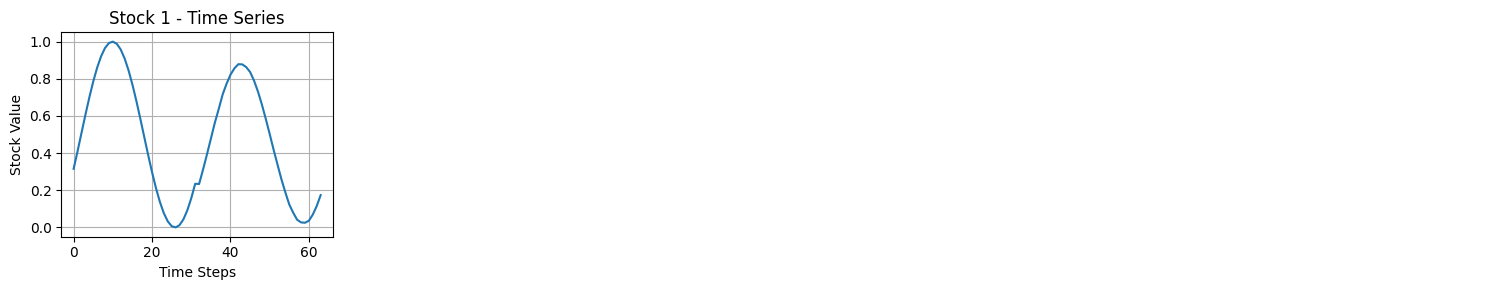

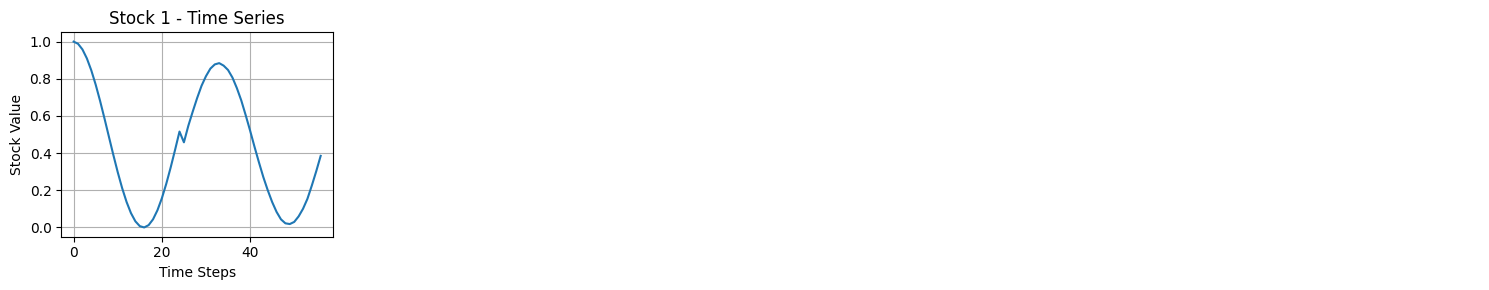

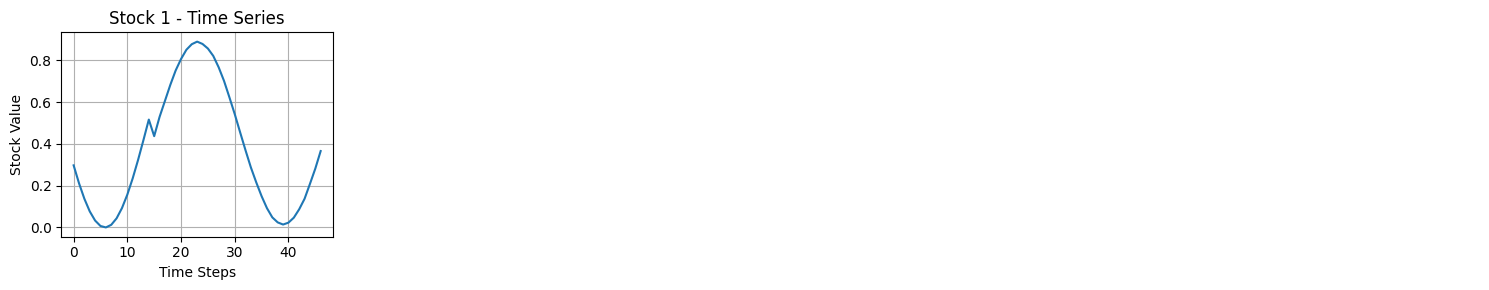

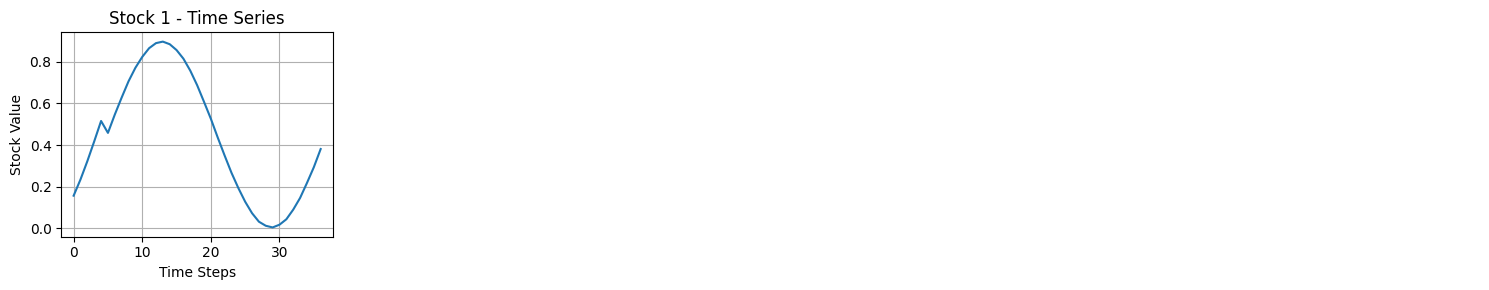

IndexError: index -1 is out of bounds for dimension 1 with size 0

In [10]:
for i in range(0, 20):
    sh = 10 * i
    context = inp_clean_data[sh:pred_ahead+sh, :].unsqueeze(0)  # Use last block_size days as context
    pr = trainer1.gen(context)

    prediction = pr[:,-1,:]#.transpose(0,1)
    
    # plot_timeseries( context[:,:,0], num_charts=1)
    # plot_timeseries( prediction, num_charts=1)

    to_plot = torch.cat([context[:,:,0], prediction], dim=1)
    plot_timeseries( to_plot, num_charts=1)